In [1]:
%%time
import manager_dataset as MD
import question_processing as QP
import nltk
from gensim.models import KeyedVectors

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Wall time: 21.3 s


In [2]:
questions = MD.questions()

### Treat text, select questions and separe data for training and testing

Question text is treated

In [3]:
for question in questions:
    if question['question'] is None:
        question['question'] = ''
    question['question'].replace('\n','').replace('\\', '').replace(u'«', '"').replace(u'»', '"').strip()

Questions without text will be removed

In [4]:
selecteds = []

for question in questions:
    if len(question['question']) > 0:
        selecteds.append(question)

questions = selecteds

The questions that has a answer will be used for test while another questions will be used for train.

In [5]:
train_questions = []
test_questions = []
for question in questions:
    if len(question['answers']) > 0:
        test_questions.append(question)
    else:
        train_questions.append(question)

print('Training:',len(train_questions))
print('Test:',len(test_questions))

Training: 3408
Test: 968


### Question Classification

Prepera the questions to train and test

In [6]:
qc_X_train = []
qc_y_train = []

qc_X_test = []
qc_y_test = []

# Select what class will be inconsiderate
def inconsiderate_classes(c):
    if c == None:
        return True
    if c == 'X':
        return True
    if c == 'MANNER':
        return True
    if c == 'OBJECT':
        return True
    if c == 'OTHER':
        return True
    return False

cls = {}  # Visualize the class distribuition
for question in train_questions:
    
    if inconsiderate_classes(question['class']):
        continue
    
    if question['class'] not in cls:
        cls[question['class']] = 0
    cls[question['class']] += 1
    
    text = question['question']
    text = text.lower()
    text = nltk.word_tokenize(text)
    qc_X_train.append(text)
    qc_y_train.append(question['class'])

print(cls)

cls = {}  # Visualize the class distribuition
for question in test_questions:
    
    if inconsiderate_classes(question['class']):
        continue
    
    if question['class'] not in cls:
        cls[question['class']] = 0
    cls[question['class']] += 1
    
    text = question['question']
    text = text.lower()
    text = nltk.word_tokenize(text)
    qc_X_test.append(text)
    qc_y_test.append(question['class'])

print(cls)
print('Train',len(qc_y_train),'Test',len(qc_y_test))

{'TIME': 273, 'PERSON': 410, 'MEASURE': 376, 'DEFINITION': 453, 'LOCATION': 376, 'ORGANIZATION': 259}
{'LOCATION': 169, 'PERSON': 172, 'DEFINITION': 171, 'MEASURE': 126, 'TIME': 91, 'ORGANIZATION': 97}
Train 2147 Test 826


Load Word2Vec model

In [7]:
%%time
w2v_patch = 'data/word_embedding/cbow_s300.txt'
w2v = KeyedVectors.load_word2vec_format(w2v_patch, unicode_errors="ignore")
model_w2v = {w: vec for w, vec in zip(w2v.index2word, w2v.syn0)}

Wall time: 3min 39s


Training

In [29]:
%%time
classifier = QP.svm_classifier()
vectorizer = QP.HybridVectorizer(model_w2v)
#vectorizer = QP.MeanEmbeddingVectorizer(model_w2v)
#vectorizer = QP.TfidfHybridVectorizer(model_w2v)
#vectorizer = QP.SequenceHybridVectorizer(model_w2v)
#vectorizer = QP.count_vectorizer(model_w2v)
#vectorizer = QP.tfidf_vectorizer(model_w2v)

model = QP.train_model(qc_X_train, qc_y_train, classifier, vectorizer)

end training
Wall time: 3.34 s


Testing

In [30]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix


result = model.predict(qc_X_test)
print('Accuracy:', accuracy_score(result, qc_y_test))
print('F1 Score:', f1_score(result, qc_y_test, average="macro"))
confusion_matrix = confusion_matrix(result, qc_y_test, labels=['DEFINITION', 'LOCATION', 'MEASURE', 'ORGANIZATION', 'PERSON', 'TIME'])

Accuracy: 0.89588377724
F1 Score: 0.885557052976


<IPython.core.display.Javascript object>


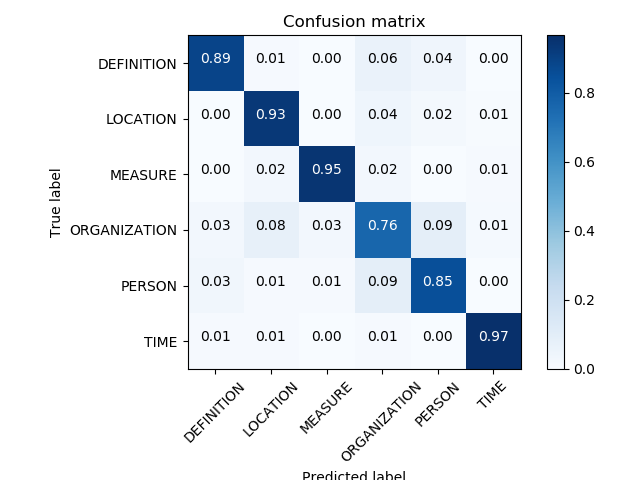

In [31]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import itertools


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
plot_confusion_matrix(confusion_matrix, ['DEFINITION', 'LOCATION', 'MEASURE', 'ORGANIZATION', 'PERSON', 'TIME'], normalize=True)